# Korg basics
If you want to run this notebook yourself, make sure to install [IJulia](https://github.com/JuliaLang/IJulia.jl) and [PyPlot](https://github.com/JuliaPy/PyPlot.jl) along with Korg. You can find the files you'll need [here](https://github.com/ajwheeler/Korg.jl/tree/main/misc/Tutorial%20notebooks).  Make sure you are using Julia 1.7 or greater, or you won't get the most recent version of Korg when you `Pkg.add` it.

In [1]:
using Korg, PyPlot

First, load a linelist.  This one was created using VALD's "extract stellar" feature. The [`read_linelist`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.read_linelist) function, which is automatically exported when you do `using Korg` loads a linelist file (VALD, Kurucz, and MOOG formats accepted), and returns a vector of `Korg.Line` objects, which are structs containing the wavelength, $\log(gf)$, species, lower energy level, and broadening parameters for a transition.

In [2]:
lines = read_linelist("linelist.vald", format="vald")

19236-element Vector{Korg.Line{Float64}}:
 Fe I 3000.0414 Å
 Fe I 3000.0639 Å
 V I 3000.1011 Å
 Cr II 3000.1718 Å
 Fe I 3000.198 Å
 Fe I 3000.2891 Å
 Fe I 3000.3859 Å
 Ca I 3000.5197 Å
 Ti II 3000.5209 Å
 Co I 3000.5851 Å
 Ti II 3000.7946 Å
 Cr II 3000.8083 Å
 Fe I 3000.8374 Å
 ⋮
 Fe I 8945.52 Å
 Fe I 8947.6451 Å
 Fe I 8948.7164 Å
 Cr I 8949.6385 Å
 Si I 8951.5481 Å
 Ni I 8968.3967 Å
 Ni I 8970.6043 Å
 Fe I 8977.8649 Å
 Cr I 8979.3295 Å
 Ti II 8981.6578 Å
 Fe I 8987.3527 Å
 Fe I 8997.0972 Å

We also need a model atmosphere.  `read_model_atmosphere` (also exported by Korg automatically) parses MARCS-format model atmosphere files, returning either a `Korg.PlanarAtmosphere` or `Korg.ShellAtmosphere` object.  

In [3]:
atm = read_model_atmosphere("s6000_g+1.0_m0.5_t05_st_z+0.00_a+0.00_c+0.00_n+0.00_o+0.00_r+0.00_s+0.00.mod")

Korg.ShellAtmosphere{Float64} with 56 layers

Now we can synthesize a stellar spectrum. Pass the linelist and atmosphere to `synÅsize`, along with upper and lower wavelengths (in Å). Korg uses wavelengths *in vacuo*, but you can use [`Korg.air_to_vacuum`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.air_to_vacuum) and [`Korg.vacuum_to_air`](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.vacuum_to_air) to convert back and forth. `synthesize` will also do this conversion automatically if you ask it to. See [the documentation](https://ajwheeler.github.io/Korg.jl/stable/API/#Korg.synthesize) for a complete list of optional arguments.
`format_A_X()` returns the solar abundance pattern in the required format.

Julia is just-in-time compiled, which means that the first time in each session you call a method (e.g. `synthesize`, `read_linelist`, or `read_model_atmosphere`), the code will be compiled, which can take several seconds.  Here, we're using the `@time` macro to see how long each call to `synthesize` takes. The first one kinda slow, with lots of time devoted to compilation. When we call it a second time, it's much faster, because no code needs to be compiled. Note that no data is being cached an re-used here.  The wavelength range is different and if we used a new atmosphere and linelist it would be just as fast.

In [4]:
# the semicolon supresses the output, so the notebook doesn't print everything returned by synthesize
@time synthesize(atm, lines, format_A_X(0), 4000, 4030); 

 27.662383 seconds (90.11 M allocations: 4.620 GiB, 5.87% gc time, 99.28% compilation time)


In [5]:
@time sol = synthesize(atm, lines, format_A_X(0), 5000, 5030); 

  0.221117 seconds (939.03 k allocations: 62.307 MiB, 21.55% gc time)


`synthesize` returns a named tuple containing the spectrum, and a couple other useful quantities.

In [6]:
keys(sol)

(:flux, :intensity, :alpha, :number_densities, :wavelengths)

`flux` and `wavelengths` are exactly what they sound like, and can be accessed like this:

In [7]:
sol.flux

3001-element Vector{Float64}:
 1.4243974385283202e15
 1.4244316069668912e15
 1.4244263870390048e15
 1.4244209727094182e15
 1.4244153774485452e15
 1.4244096128770608e15
 1.4244036889976238e15
 1.4243935833153475e15
 1.424387260465857e15
 1.424380796250274e15
 1.42437419562748e15
 1.424367462626044e15
 1.4243606004229508e15
 ⋮
 1.41460333161971e15
 1.4146118553313918e15
 1.4146576808828158e15
 1.4146581062735802e15
 1.414658288603967e15
 1.4146582497297908e15
 1.4146580089397018e15
 1.4146575833111618e15
 1.4146569880099888e15
 1.4146562365433995e15
 1.4146553409742692e15
 1.4146483969097208e15

In [8]:
sol.wavelengths

5000.0:0.01:5030.0

We can plot them with PyPlot like this:

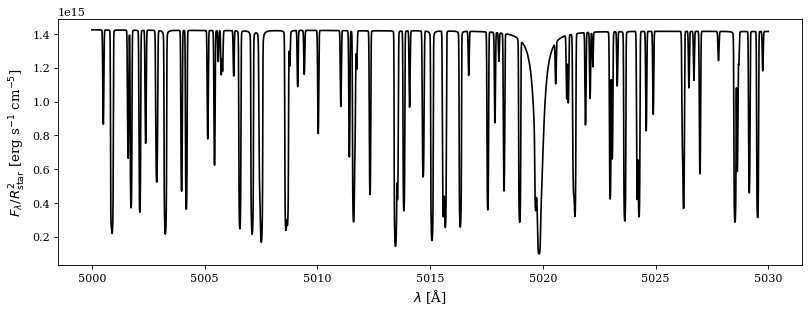

In [9]:
figure(figsize=(12, 4))
plot(sol.wavelengths, sol.flux, "k-")
xlabel(L"$\lambda$ [Å]")
ylabel(L"$F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]");

By default, Korg uses the solar element abundances. When constructing an abundance vector with `format_A_X`, the `metallicity` keyword lets you set \[metals/H\], and the `abundances` keyword argument lets you specify abundances in $A(X)$ form.  Let's synthesize a couple more spectra with slightly different abundances and take a look at the results.

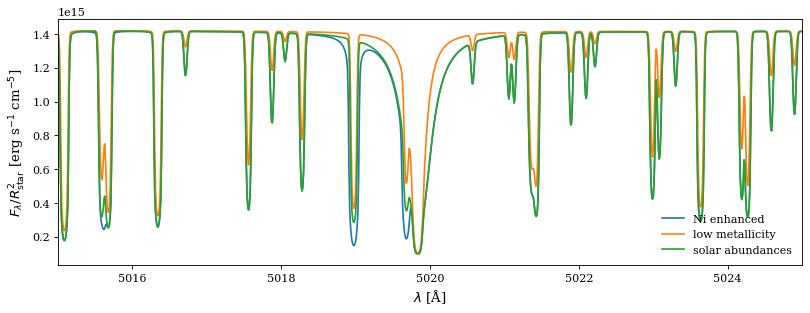

In [10]:
metal_poor_A_X = format_A_X(-0.5)
low_metalicity_sol = synthesize(atm, lines, metal_poor_A_X, 5015, 5025)

Ni_enriched_A_X = format_A_X(Dict("Ni"=>1.5))
Ni_enriched_sol = synthesize(atm, lines, Ni_enriched_A_X, 5015, 5025)

figure(figsize=(12, 4))
plot(Ni_enriched_sol.wavelengths, Ni_enriched_sol.flux, label="Ni enhanced")
plot(low_metalicity_sol.wavelengths, low_metalicity_sol.flux, label="low metallicity")
plot(sol.wavelengths, sol.flux, label="solar abundances")
xlabel(L"$\lambda$ [Å]")
ylabel(L"$F_\lambda/R_\mathrm{star}^2$ [erg s$^{-1}$ cm$^{-5}$]")
xlim(5015, 5025)
legend();

`sol.alpha` is a matrix containing the absorption coefficient, $\alpha$ at each wavelength and atmospheric layer.  We can plot $\alpha$ as a function of wavelength like this.

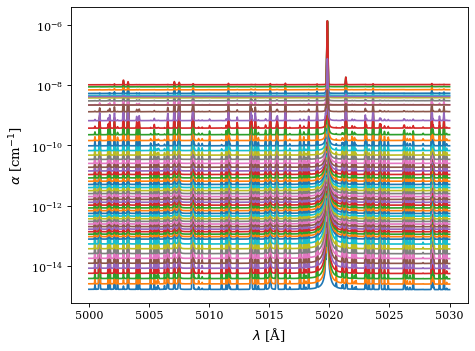

In [11]:
plot(sol.wavelengths, sol.alpha'); # sol.alpha' is the adjoint of sol.alpha.
yscale("log")
xlabel(L"$\lambda$ [Å]")
ylabel(L"$\alpha$ [cm$^{-1}$]");

Let's look at the last bit of info that synthesize returns.  `sol.number_densities` is a dictionary which maps Korg `Species` objects to their number densities in each layer of the atmosphere.

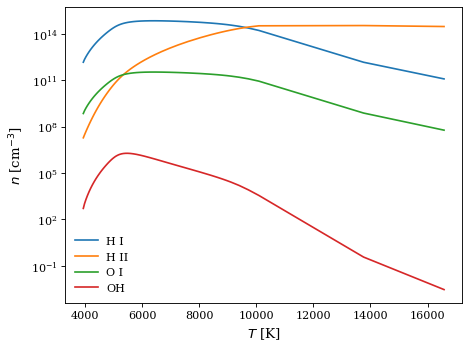

In [12]:
temps = [l.temp for l in atm.layers] #use an array comprension to pull out the temperature of each layer in the model atmosphere

# These strings represent different species. Below, we pass them to Korg.Species to construct a Species object.
for spec in ["H I", "H II", "O I", "OH"] 
    plot(temps, sol.number_densities[Korg.Species(spec)], label=spec)
end

legend()
yscale("log")
xlabel(L"$T$ [K]")
ylabel(L"$n$ [cm$^{-3}$]");